# Assignment 6: Convolutional Networks

Before we start, we should assure that we have activated CUDA -- otherwise training might take very long.
In Google Colaboratory:

1. Check the options Runtime -> Change Runtime Type on top of the page.
2. In the popup window, select hardware accelerator GPU.

Afterward, the following command should run successfully:

In [2]:
import torch
if torch.cuda.is_available():
  print("Successfully enabled CUDA processing")
else:
  print("CUDA processing not available. Things will be slow :-(")

Successfully enabled CUDA processing


## Dataset

In PyTorch, a dataset stores a list of input and target tensors $(X^n, T^n)$.
In case of **MNIST** dataset, the inputs are $X^n \in \mathbb R^{28\times28}$ and $T^n \in \{0,\ldots,9\}$.
More precisely, the data in the dataset is provided in form of `PIL.Image.Image`, which represents an image class with some more functionality, and pixel values in range $[0, 255]$.
In order to convert these images into `torch.Tensor`'s in range $[0,1]$, we can use the [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) transform.
Furthermore, in `PyTorch` batches are created from datasets using the [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class.


### Task 1: Dataset Loading


Here, we use the [MNIST dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) of gray images for categorical classification.

Write a function that returns the training and the testing set of MNIST, using the given transform.

In [3]:
import torch
import torchvision
from torchvision import transforms

def datasets(transform):
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    return trainset, testset

### Test 1: Data Types

When we create the dataset with `transform=None`, all inputs shall be of type `PIL.Image.Image`, and all targets are integral.

In [4]:
import PIL
trainset, testset = datasets(transform=None)

for x,t in trainset:
  # check datatype of input x
  assert isinstance(x, PIL.Image.Image)
  # check datatype of target t
  assert isinstance(t, int)

100%|██████████| 9912422/9912422 [00:00<00:00, 428160934.72it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 108641877.87it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 231827949.74it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22049223.11it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Task 2: Data Loaders


Create the dataset with transform `ToTensor`. Create two data loaders, one for the training set and one for the testing set. The training batch size should be $B=64$, for the testing set, you can select any batch size of your choice.


In [5]:
import torch
import torchvision
from torchvision import transforms

# Define the transform to use
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset with the transform applied
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define the batch size
B = 64

# Create a data loader for the training set with batch size B and shuffle the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=B, shuffle=True)

# Create a data loader for the testing set with any batch size (e.g. 32) and do not shuffle the data
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)


### Test 2: Batches

Check that all batches generated by the training set data loader have the batch size of $B$ -- except for the last batch, which you need to compute by yourself (you might want to make use of the modulo operator `%`).

Afterward, we check that all inputs and targets are of type `torch.Tensor`, that all input values are in range $[0,1]$ and that all target values are in range $[0,9]$.

In [6]:
# compute the size of last batch
last_batch = len(trainset) % B

for x,t in trainloader:
  # check datatype, size and content of x
  assert isinstance(x, torch.Tensor)
  assert(torch.all(x >= 0)) and torch.all(x <= 1)  
  assert (len(x)==B) or (len(x) == last_batch)  # <-- corrected condition

  # check datatype, size and content of t
  assert isinstance(t, torch.Tensor)
  assert(torch.all(t >= 0)) and torch.all(t <= 9)
  assert (len(t)==B) or (len(t) == last_batch)  # <-- corrected condition

## Networks
As last week, we will rely on [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to create networks with particular lists of consecutive layers.
Particularly, we will investigate two different versions of networks, one fully-connected network and one convolutional network, with the same number of learnable layers.

### Task 3: Fully-Connected Network


Implement a function that returns a three-layer fully-connected network in `pytorch`.
Use $\tanh$ as activation function between the two fully-connected layers, and provide the possibility to change the number of inputs $D$, the number of hidden neurons $K$ and the number of outputs $O$.
Use the following layers:

1. A [Flatten layer](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) to turn the $28\times28$ pixel image (2D) into a $28\cdot28$ pixel vector (1D).
2. A [fully-connected layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) with D input neurons and K outputs.
3. A [$\tanh$ activation function](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).
4. A fully-connected layer with K input neurons and K outputs.
5. A $\tanh$ activation function.
6. A fully-connected layer with K input neurons and O outputs.

In [7]:
def fully_connected(D, K, O):
    return torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(D, K),
        torch.nn.Tanh(),
        torch.nn.Linear(K, K),
        torch.nn.Tanh(),
        torch.nn.Linear(K, O)
    )

### Task 4: Convolutions Output (theoretical question)

Consider the network as defined in Task 5.
Assume that the input is a $28\times28$ grayscale image.
How many hidden neurons do we need in the final fully-connected layer for a given number $Q_2$ of output channels of the second convolution?
 

In a convolutional neural network, the output of the convolutional layers is a 3D tensor of shape (batch_size, channels, height, width), where "channels" refers to the number of channels produced by the convolutional layer, and "height" and "width" refer to the height and width of the output feature maps.

In this case, we start with a $28 \times 28$ grayscale image as input, which is a single channel, so the output of the first convolutional layer will have $Q_1$ channels and a height and width of $28$ (since we used "same" padding). Then we apply max pooling with a pooling size of $2 \times 2$ and a stride of 2, which reduces the height and width by a factor of 2, giving us a 3D tensor with $Q_1$ channels and a height and width of 14.

We then apply a second convolutional layer with $Q_2$ channels, which produces a 3D tensor with $Q_2$ channels and a height and width of 14 (again, due to the "same" padding). We apply another max pooling operation, which reduces the height and width to 7. Finally, we flatten the output and pass it through a fully connected layer with $O$ outputs.

To determine the number of inputs to this fully connected layer, we need to compute the total number of features in the output of the second convolutional layer. The number of features in the output is simply the product of the number of channels, height, and width. In this case, we have $Q_2$ channels and a height and width of 7, so the total number of features is $Q_2 \times 7 \times 7 = 49Q_2$. Therefore, the number of inputs to the fully connected layer is 49 times the number of channels in the output of the second convolutional layer, which is $49Q_2$.

So to answer the original question, for a given number $Q_2$ of output channels of the second convolutional layer, we need $49Q_2$ hidden neurons in the final fully connected layer.

### Task 5: Convolutional Network

Implement a function that generates a convolutional network with the following layers:

1. A [2D convolutional layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with $Q_1$ channels, kernel size $5\times5$, stride 1 and padding 2.
2. A [2D maximum pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) with pooling size $2\times2$ and stride 2.
3. A $\tanh$ activation function.
4. A 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2.
5. A 2D maximum pooling with pooling size $2\times2$ and stride 2.
6. A $\tanh$ activation function.
7. A flattening layer to turn the 3D feature map into a 1D vector.
8. A fully-connected layer with the appropriate number of inputs and $O$ outputs.

In [8]:
def convolutional(Q1, Q2, O):
    return torch.nn.Sequential(
        torch.nn.Conv2d(1, Q1, kernel_size=5, stride=1, padding=2),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        torch.nn.Tanh(),
        torch.nn.Conv2d(Q1, Q2, kernel_size=5, stride=1, padding=2),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        torch.nn.Tanh(),
        torch.nn.Flatten(),
        torch.nn.Linear(Q2*7*7, O)
    )


## Network Training
For training and evaluating the network, we rely on standard functionality in PyTorch.
We use the standard [categorical cross-entropy loss](https://pytorch.org/docs/stable/nn.html#loss-functions) together with a [stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer.
For training, we use the batched implementation of the dataset, for which we perform one update step for each training batch.
After having gone through the full training dataset, we compute accuracy and loss values for the testing set (we simply make use of the testing set for validation).


### Task 6: Training and Validation Loop

Implement a function that takes the network, the number of epochs, and the learning rate.
Select the correct loss function for categorical classification and SGD optimizer.
Iterate the following steps for the given number of epochs:

1. Train the network with all batches of the training data.
2. Compute the testing set loss and testing set accuracy.
3. Store both in a vector.

What do we need to take care of?

Finally, return the lists of validation losses and accuracies.

There is a few things we need to be careful of; in the training function,

1. Selecting the appropriate loss function and optimizer for categorical classification.
2. Instantiating the correct device for training on GPU if available.
3. Collecting loss values and accuracies over the training epochs.
4. Training the network on all batches of the training data for each epoch.
5. Computing the validation loss and accuracy on the testing data after each epoch.

In [9]:
def train(network, epochs, eta, momentum):
    # select loss function and optimizer
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(network.parameters(), lr=eta, momentum=momentum)

    # instantiate the correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = network.to(device)

    # collect loss values and accuracies over the training epochs
    val_loss, val_acc = [], []

    for epoch in range(epochs):
        # train network on training data
        network.train() # set to train mode
        for x, t in trainloader:
            # put data to device
            x, t = x.to(device), t.to(device)

            # train
            optimizer.zero_grad()
            y = network(x)
            loss = loss_fn(y, t)
            loss.backward()
            optimizer.step()

        # test network on test data
        network.eval() # set to evaluation mode
        correct, total_loss = 0, 0
        with torch.no_grad():
            for x, t in testloader:
                # put data to device
                x, t = x.to(device), t.to(device)

                # compute validation loss
                y = network(x)
                loss = loss_fn(y, t)
                total_loss += loss.item()

                # compute validation accuracy
                _, predicted = torch.max(y.data, 1)
                correct += (predicted == t).sum().item()

        # store loss and accuracy values
        avg_loss = total_loss / len(testloader.dataset)
        avg_acc = correct / len(testloader.dataset)
        val_loss.append(avg_loss)
        val_acc.append(avg_acc)

    # return loss and accuracy values
    return val_loss, val_acc


### Task 7: Fully-Connected Training

Create a fully-connected network with $K=100$ hidden and $O=10$ output neurons.
Train the network for 10 epochs with $\eta=0.01$, $momentum=0.9$ and store the obtained test losses and accuracies.
Brave people can also train for 100 epochs (which will take up to 30 minutes).

In [10]:
# Create the network
fc = fully_connected(28*28, 100, 10)

# Train the network for 2 epochs with a learning rate of 0.01 and momentum of 0.9
fc_loss, fc_acc = train(fc, 100, 0.01, 0.9)

### Task 8: Convolutional Training


Create a convolutional network with $Q_1=16$ and $Q_2=32$ convolutional channels and $O=10$ output neurons.
Train the network for 10 epochs with $\eta=0.01$, momentum $=0.9$ and store the obtained test losses and accuracies.
Again, 100 epochs will take up to 30 minutes.

In [11]:
# Define the network architecture
cv = convolutional(16, 32, 10)

# Train the network for 2 epochs with a learning rate of 0.01 and momentum of 0.9
cv_loss, cv_acc = train(cv, 100, 0.01, 0.9)

### Task 9: Plotting

Plot the two lists of loss values in one plot. Plot the two lists of accuracy values into another plot.

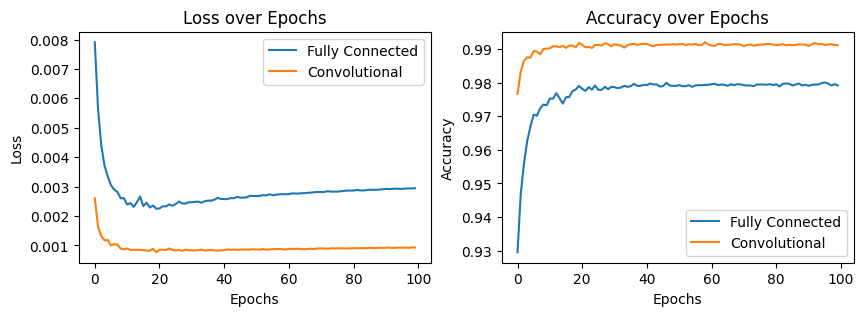

In [12]:
from matplotlib import pyplot

# plot loss values of FC and CV network over epochs
pyplot.figure(figsize=(10, 3))
ax = pyplot.subplot(121)
pyplot.plot(fc_loss, label='Fully Connected')
pyplot.plot(cv_loss, label='Convolutional')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
ax.set_title('Loss over Epochs')
pyplot.legend()

# plot accuracy values of FC and CV network over epochs
ax = pyplot.subplot(122)
pyplot.plot(fc_acc, label='Fully Connected')
pyplot.plot(cv_acc, label='Convolutional')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
ax.set_title('Accuracy over Epochs')
pyplot.legend()

pyplot.show()

Looking at the "Loss over Epochs" graph, we can see that for both the fully connected and convolutional networks, the loss value drops rapidly to a minimum initially, with the convolutional network achieving a lower value.

The fluctuations we see just after this drop are caused by the optimization algorithm (SGD in this case) trying to find the optimal weights and biases for the networks such that the loss function is minimized, being done iteratively. The algorithm takes a step that increases the loss temporarily before converging towards the optimal solution, as in the case of the convolutional network. This is especially prevalent if the learning rate is high or when the algorithm encounters a saddle point or a local minimum.

The increasing loss value we see in the fully connected network is probably caused by the network becoming overfit to the training data. The model becomes too specialized to the training data and is unable to generalize to new data, or the learning rate is too high, causing the model to overshoot the optimal weights during training. One way to fix this problem would be to implement a training indicator that monitors the loss value. If the loss value after x number of epochs has the overall increasing trend, we can stop the network from training and thereby prevent overfitting.

Now looking at the "Accuracy over Epochs" graph, we see a rapid increase in the accuracy value at the start. This corresponds to the network's initial training as the weights and biases quickly converge to the global minimum of the loss function. The same fluctuations are also seen in the graph after this increase for the same reasons we see them in the loss graph. However, the key takeaway is that the convolutional network achieved a much higher accuracy value compared to the fully connected network, making it the superior network in this case. The reason for this is:

Convolutional neural networks (CNNs) are particularly designed to work with image data, which has a high-dimensional structure with local spatial correlations between neighboring pixels. In contrast, a fully connected neural network (FCNN) is designed to work with one-dimensional data such as time series or flattened images.

CNNs can learn spatial features of images using convolutional and pooling layers, which can reduce the number of parameters and extract relevant features in a hierarchical manner. This allows the network to focus on relevant spatial features, such as edges and corners, and reduce the sensitivity to irrelevant variations in the image.

FCNNs, on the other hand, may struggle to capture the relevant spatial features due to their lack of built-in spatial invariance. They rely on the input data to be flattened, and thus lose the original spatial structure of the data. This means that FCNNs have to learn the spatial features in a more complex and computationally expensive way by increasing the number of neurons and layers.

### Task 10: Learnable Parameters 

Estimate roughly how many learnable parameters the two networks have by analytically computing and adding the number of parameters in each layer.

Fully-connected Network:

- Flatten layer: 0 parameters (no learnable weights or biases)
- First fully-connected layer: (D x K) + K = (28*28) * 100 + 100 = 78500 parameters
- Tanh activation function: 0 parameters 
- Second fully-connected layer: (D x K) + K = 100 * 100 + 100 = 10100 parameters
- Tanh activation function: 0 parameters 
- Third fully-connected layer: (D x K) + K = 100 * 10 + 10 = 1010 parameters
- Total: 89610

Convolutional Network:

- 2D convolutional layer: C x (F x E x E + F) = 16 x (5 x 5 x 1 + 1) = 416
- 2D maximum pooling layer: 0
- Tanh activation function: 0
- 2D convolutional layer: C x (F x K x K + F) = 32 x (5 x 5 x 16 + 1) = 12,832
- 2D maximum pooling layer: 0
- Tanh activation function: 0
- Flattening layer: 0
- Fully-connected layer: D x K + K = 1568 x 10 + 10 = 15,690
- Total: 28,938

Where input has D neurons, the output has K neurons, C is input channel number, F is output filters, the kernel has size E and F biases

Now, compute the number of parameters in the networks by summing the number of parameters in each layer using `pytorch` functionality.
You can use the `numel()` function from a `torch.Tensor` to provide the number of (learnable) parameters stored in a tensor.
How do you obtain this list of all learnable parameters from a `pytorch` [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)?

In [17]:
def parameter_count(network):
    return sum(p.numel() for p in network.parameters() if p.requires_grad)

print("Fully-connected Network:", parameter_count(fc))
print("Convolutional Network:", parameter_count(cv))

Fully-connected Network: 89610
Convolutional Network: 28938


The pooling, activation, and flattening layers do not have learnable parameters because they do not change the weights of the network during training. With pooling layer performs a fixed operation (e.g. taking the maximum value within a certain kernel) that does not require any learnable parameters. Similarly, the activation layer only applies a fixed function to its inputs (tanh in this case) that does not require any learnable parameters. Finally, the flattening layer simply restructures the tensor from a higher-dimensional tensor to a 1D tensor without modifying any values, and thus also has no learnable parameters.